In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
import spacy
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from fastapi import FastAPI, Request
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import mlflow
import mlflow.pytorch

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

# Chemin vers le fichier CSV contenant les données de catégories
fichier = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_007/training_1600000_processed_noemoticon.csv'

with open(fichier, 'rb') as file:
    bytes_data = file.read()  # lire le fichier en mode binaire
    decoded_data = bytes_data.decode('latin-1')  # essayer de décoder en utilisant latin-1

from io import StringIO
import pandas as pd

data = pd.read_csv(StringIO(decoded_data))

# Liste des noms de colonnes
noms_colonnes = ['Groupe', 'id_uti', 'date_voyage', 'requete', 'pseudo_uti', 'tweet']

# Lire le fichier CSV avec les noms de colonnes spécifiés
data = pd.read_csv(fichier, names=noms_colonnes, header=None)

In [3]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import spacy
import mlflow
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch

# Charger le modèle anglais de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour nettoyer le texte
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s#]', '', text).lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Fonction pour lemmatiser le texte
def lemmatize_text(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Utiliser seulement X% des données pour le développement initial
data_sample = data.sample(frac=0.00025, random_state=42)

# Nettoyage du texte
data_sample['tweet'] = data_sample['tweet'].fillna('')
data_sample['cleaned_text'] = data_sample['tweet'].apply(clean_text)

# Lemmatisation
data_sample['lemmatized_tokens'] = data_sample['cleaned_text'].apply(lemmatize_text)

# Entrainement du modèle Word2Vec
word2vec_model = Word2Vec(sentences=data_sample['lemmatized_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Transformation des textes en vecteurs
data_sample['word2vec_vectors'] = data_sample['lemmatized_tokens'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x if word in word2vec_model.wv], axis=0).tolist())

# Assurez-vous de remplacer 'local_path_to_use_model' par le chemin réel du modèle téléchargé
use_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

# Fonction pour obtenir l'embedding USE
def embed_use(text):
    return use_model([text]).numpy().flatten()

# Embedding des textes avec USE
data_sample['use_embeddings'] = data_sample['lemmatized_tokens'].apply(lambda x: embed_use(" ".join(x)))

# Préparation des données pour l'entraînement
data_sample['labels'] = data_sample['Groupe'].apply(lambda x: 1 if x == 4 else 0)  # Convertir en 0 et 1
data_sample = data_sample[['tweet', 'labels', 'word2vec_vectors', 'use_embeddings']]

# Séparer les données en jeu d’entraînement (70%), jeu de validation (15%) et jeu de test (15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(data_sample['tweet'], data_sample['labels'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EvalPrediction
from sklearn.model_selection import train_test_split, KFold
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

class MetricsRecorder:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

    def log_metrics(self, logs, split):
        print(f"Available keys in logs for {split}: {logs.keys()}")  # Ajout de cette ligne pour imprimer les clés disponibles
        if split == 'train':
            self.train_loss.append(logs['eval_loss'])  # Utiliser 'eval_loss' pour l'entraînement aussi
            self.train_accuracy.append(logs['eval_accuracy'])  # Utiliser 'eval_accuracy' pour l'entraînement aussi
        elif split == 'val':
            self.val_loss.append(logs['eval_loss'])
            self.val_accuracy.append(logs['eval_accuracy'])

    def get_metrics(self):
        return {
            'train_loss': self.train_loss,
            'val_loss': self.val_loss,
            'train_accuracy': self.train_accuracy,
            'val_accuracy': self.val_accuracy
        }

    def print_metrics(self):
        print("Train Loss: ", self.train_loss)
        print("Validation Loss: ", self.val_loss)
        print("Train Accuracy: ", self.train_accuracy)
        print("Validation Accuracy: ", self.val_accuracy)

texts = data_sample['tweet'].fillna('').tolist()
labels = data_sample['labels'].tolist()  # Assurez-vous que les labels sont binaires (0 ou 1)

# Séparer les données en jeu d’entraînement (70%), jeu de validation (15%) et jeu de test (15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Préparation des données pour BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_bert_input(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,                      # Phrase à encoder
            add_special_tokens=True,   # Ajouter les tokens spéciaux [CLS] et [SEP]
            max_length=max_length,     # Longueur maximale de la séquence
            pad_to_max_length=True,    # Pad & truncate toutes les phrases
            return_attention_mask=True,# Retourner les masks d'attention
            return_tensors='pt',       # Retourner les tenseurs PyTorch
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

train_inputs, train_masks = prepare_bert_input(train_texts, tokenizer)
val_inputs, val_masks = prepare_bert_input(val_texts, tokenizer)
test_inputs, test_masks = prepare_bert_input(test_texts, tokenizer)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Création des datasets pour BERT
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'attention_mask': self.masks[idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_inputs, train_masks, train_labels)
val_dataset = TweetDataset(val_inputs, val_masks, val_labels)
test_dataset = TweetDataset(test_inputs, test_masks, test_labels)

# Configuration de MLFlow
mlflow.set_experiment("BERT Sentiment Analysis")

# Définir une fonction de calcul de la précision
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

# Variables pour stocker les résultats
val_results_all_folds = []
test_results_all_folds = []
metrics_recorder = MetricsRecorder()

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(data_sample)):
    train_texts = data_sample.iloc[train_idx]['tweet'].values
    val_texts = data_sample.iloc[val_idx]['tweet'].values
    train_labels = data_sample.iloc[train_idx]['labels'].values
    val_labels = data_sample.iloc[val_idx]['labels'].values

    train_encodings = prepare_bert_input(train_texts, tokenizer)
    val_encodings = prepare_bert_input(val_texts, tokenizer)

    train_dataset = TweetDataset(*train_encodings, train_labels)
    val_dataset = TweetDataset(*val_encodings, val_labels)
    
    # Charger le modèle pré-entraîné BERT pour la classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Configuration des arguments de l'entraînement
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold}',    # sortie des résultats pour chaque fold
        num_train_epochs=6,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs_fold_{fold}',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Initialiser Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Entraîner le modèle
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run():
        trainer.train()

        # Enregistrer les métriques d'entraînement
        train_metrics = trainer.evaluate(eval_dataset=train_dataset)
        metrics_recorder.log_metrics(train_metrics, split='train')

        # Évaluer sur le jeu de validation
        val_results = trainer.evaluate(eval_dataset=val_dataset)
        val_results_all_folds.append(val_results)
        metrics_recorder.log_metrics(val_results, split='val')
        print(f"Validation results for fold {fold}: {val_results}")

        # Évaluer sur le jeu de test
        test_results = trainer.evaluate(eval_dataset=test_dataset)
        test_results_all_folds.append(test_results)
        print(f"Test results for fold {fold}: {test_results}")

# Sauvegarder le modèle finetuné
model.save_pretrained("./finetuned_BERT")
tokenizer.save_pretrained("./finetuned_BERT")

# Débogage : Afficher les métriques enregistrées
metrics_recorder.print_metrics()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model check

{'loss': 0.7057, 'grad_norm': 4.503231048583984, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  8%|▊         | 20/240 [03:08<34:30,  9.41s/it]

{'loss': 0.7254, 'grad_norm': 5.220008373260498, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


 12%|█▎        | 30/240 [04:36<31:07,  8.89s/it]

{'loss': 0.6702, 'grad_norm': 4.841641426086426, 'learning_rate': 3e-06, 'epoch': 0.75}


 17%|█▋        | 40/240 [06:03<28:19,  8.50s/it]

{'loss': 0.6743, 'grad_norm': 9.057150840759277, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}


                                                
 17%|█▋        | 40/240 [06:34<28:19,  8.50s/it]

{'eval_loss': 0.6841483116149902, 'eval_accuracy': 0.5875, 'eval_runtime': 30.8476, 'eval_samples_per_second': 2.593, 'eval_steps_per_second': 0.324, 'epoch': 1.0}


 21%|██        | 50/240 [08:02<28:59,  9.15s/it]

{'loss': 0.6725, 'grad_norm': 6.693202018737793, 'learning_rate': 5e-06, 'epoch': 1.25}


 25%|██▌       | 60/240 [09:33<26:59,  9.00s/it]

{'loss': 0.6929, 'grad_norm': 13.242101669311523, 'learning_rate': 6e-06, 'epoch': 1.5}


 29%|██▉       | 70/240 [11:00<24:25,  8.62s/it]

{'loss': 0.6234, 'grad_norm': 7.758190631866455, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 33%|███▎      | 80/240 [12:29<23:23,  8.77s/it]

{'loss': 0.6357, 'grad_norm': 5.489221572875977, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}


                                                
 33%|███▎      | 80/240 [12:57<23:23,  8.77s/it]

{'eval_loss': 0.6286779642105103, 'eval_accuracy': 0.725, 'eval_runtime': 28.1627, 'eval_samples_per_second': 2.841, 'eval_steps_per_second': 0.355, 'epoch': 2.0}


 38%|███▊      | 90/240 [14:30<24:49,  9.93s/it]

{'loss': 0.6179, 'grad_norm': 5.248582363128662, 'learning_rate': 9e-06, 'epoch': 2.25}


 42%|████▏     | 100/240 [15:57<20:09,  8.64s/it]

{'loss': 0.5539, 'grad_norm': 7.461988925933838, 'learning_rate': 1e-05, 'epoch': 2.5}


 46%|████▌     | 110/240 [17:25<19:15,  8.89s/it]

{'loss': 0.5506, 'grad_norm': 7.49491548538208, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 50%|█████     | 120/240 [18:53<17:42,  8.85s/it]

{'loss': 0.5755, 'grad_norm': 11.628167152404785, 'learning_rate': 1.2e-05, 'epoch': 3.0}


                                                 
 50%|█████     | 120/240 [19:23<17:42,  8.85s/it]

{'eval_loss': 0.5462027192115784, 'eval_accuracy': 0.7875, 'eval_runtime': 29.2987, 'eval_samples_per_second': 2.73, 'eval_steps_per_second': 0.341, 'epoch': 3.0}


 54%|█████▍    | 130/240 [20:49<16:38,  9.08s/it]

{'loss': 0.4226, 'grad_norm': 10.45574951171875, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 58%|█████▊    | 140/240 [22:17<15:00,  9.00s/it]

{'loss': 0.3801, 'grad_norm': 8.488595962524414, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 62%|██████▎   | 150/240 [23:45<13:21,  8.90s/it]

{'loss': 0.3658, 'grad_norm': 12.028729438781738, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 67%|██████▋   | 160/240 [25:14<11:58,  8.98s/it]

{'loss': 0.3781, 'grad_norm': 7.274928092956543, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}


                                                 
 67%|██████▋   | 160/240 [25:43<11:58,  8.98s/it]

{'eval_loss': 0.5990142822265625, 'eval_accuracy': 0.7125, 'eval_runtime': 29.3326, 'eval_samples_per_second': 2.727, 'eval_steps_per_second': 0.341, 'epoch': 4.0}


 71%|███████   | 170/240 [27:11<10:32,  9.04s/it]

{'loss': 0.2679, 'grad_norm': 3.925813913345337, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 75%|███████▌  | 180/240 [28:40<08:57,  8.97s/it]

{'loss': 0.1992, 'grad_norm': 2.36783766746521, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 79%|███████▉  | 190/240 [30:09<07:16,  8.72s/it]

{'loss': 0.1405, 'grad_norm': 7.01264762878418, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 83%|████████▎ | 200/240 [31:36<05:53,  8.84s/it]

{'loss': 0.1751, 'grad_norm': 6.825474739074707, 'learning_rate': 2e-05, 'epoch': 5.0}


                                                 
 83%|████████▎ | 200/240 [32:05<05:53,  8.84s/it]

{'eval_loss': 0.6030673980712891, 'eval_accuracy': 0.8125, 'eval_runtime': 29.0713, 'eval_samples_per_second': 2.752, 'eval_steps_per_second': 0.344, 'epoch': 5.0}


 88%|████████▊ | 210/240 [33:33<04:30,  9.02s/it]

{'loss': 0.0607, 'grad_norm': 0.7397575974464417, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 92%|█████████▏| 220/240 [35:00<02:57,  8.86s/it]

{'loss': 0.0428, 'grad_norm': 0.38653066754341125, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 96%|█████████▌| 230/240 [36:27<01:27,  8.74s/it]

{'loss': 0.1309, 'grad_norm': 21.64376449584961, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


100%|██████████| 240/240 [37:53<00:00,  8.31s/it]

{'loss': 0.1388, 'grad_norm': 56.94070053100586, 'learning_rate': 2.4e-05, 'epoch': 6.0}


                                                 
100%|██████████| 240/240 [38:24<00:00,  9.60s/it]


{'eval_loss': 0.7015902996063232, 'eval_accuracy': 0.8625, 'eval_runtime': 31.449, 'eval_samples_per_second': 2.544, 'eval_steps_per_second': 0.318, 'epoch': 6.0}
{'train_runtime': 2304.8843, 'train_samples_per_second': 0.833, 'train_steps_per_second': 0.104, 'train_loss': 0.43334668390452863, 'epoch': 6.0}


100%|██████████| 40/40 [01:55<00:00,  2.89s/it]


Available keys in logs for train: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


Available keys in logs for val: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Validation results for fold 0: {'eval_loss': 0.7015902996063232, 'eval_accuracy': 0.8625, 'eval_runtime': 29.4822, 'eval_samples_per_second': 2.713, 'eval_steps_per_second': 0.339, 'epoch': 6.0}


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test results for fold 0: {'eval_loss': 0.3163217604160309, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 21.6442, 'eval_samples_per_second': 2.772, 'eval_steps_per_second': 0.37, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  4%|▍         | 10/240 [01:28<32:44,  8.54s/it]

{'loss': 0.8329, 'grad_norm': 6.811552047729492, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  8%|▊         | 20/240 [02:57<31:43,  8.65s/it]

{'loss': 0.8205, 'grad_norm': 11.754175186157227, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


 12%|█▎        | 30/240 [04:26<30:31,  8.72s/it]

{'loss': 0.7621, 'grad_norm': 9.273006439208984, 'learning_rate': 3e-06, 'epoch': 0.75}


 17%|█▋        | 40/240 [05:54<30:16,  9.08s/it]

{'loss': 0.6964, 'grad_norm': 2.7470614910125732, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}


                                                
 17%|█▋        | 40/240 [06:22<30:16,  9.08s/it]

{'eval_loss': 0.8014165163040161, 'eval_accuracy': 0.4375, 'eval_runtime': 27.8456, 'eval_samples_per_second': 2.873, 'eval_steps_per_second': 0.359, 'epoch': 1.0}


 21%|██        | 50/240 [07:51<27:50,  8.79s/it]

{'loss': 0.678, 'grad_norm': 4.394837379455566, 'learning_rate': 5e-06, 'epoch': 1.25}


 25%|██▌       | 60/240 [09:19<26:41,  8.90s/it]

{'loss': 0.7395, 'grad_norm': 7.441612243652344, 'learning_rate': 6e-06, 'epoch': 1.5}


 29%|██▉       | 70/240 [10:47<26:16,  9.27s/it]

{'loss': 0.6854, 'grad_norm': 7.365184783935547, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 33%|███▎      | 80/240 [12:16<24:05,  9.04s/it]

{'loss': 0.6977, 'grad_norm': 6.938826084136963, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}


                                                
 33%|███▎      | 80/240 [12:46<24:05,  9.04s/it]

{'eval_loss': 0.6830933094024658, 'eval_accuracy': 0.5625, 'eval_runtime': 29.19, 'eval_samples_per_second': 2.741, 'eval_steps_per_second': 0.343, 'epoch': 2.0}


 38%|███▊      | 90/240 [14:14<22:59,  9.19s/it]

{'loss': 0.6243, 'grad_norm': 10.732941627502441, 'learning_rate': 9e-06, 'epoch': 2.25}


 42%|████▏     | 100/240 [15:42<21:06,  9.04s/it]

{'loss': 0.6425, 'grad_norm': 6.603384971618652, 'learning_rate': 1e-05, 'epoch': 2.5}


 46%|████▌     | 110/240 [17:11<19:03,  8.80s/it]

{'loss': 0.64, 'grad_norm': 15.340924263000488, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 50%|█████     | 120/240 [18:39<18:00,  9.01s/it]

{'loss': 0.5792, 'grad_norm': 5.999112606048584, 'learning_rate': 1.2e-05, 'epoch': 3.0}


                                                 
 50%|█████     | 120/240 [19:09<18:00,  9.01s/it]

{'eval_loss': 0.586802065372467, 'eval_accuracy': 0.675, 'eval_runtime': 29.7355, 'eval_samples_per_second': 2.69, 'eval_steps_per_second': 0.336, 'epoch': 3.0}


 54%|█████▍    | 130/240 [20:36<16:48,  9.17s/it]

{'loss': 0.5571, 'grad_norm': 7.619644641876221, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 58%|█████▊    | 140/240 [22:07<14:41,  8.81s/it]

{'loss': 0.4769, 'grad_norm': 5.686593532562256, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 62%|██████▎   | 150/240 [23:35<13:22,  8.92s/it]

{'loss': 0.4405, 'grad_norm': 16.37984848022461, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 67%|██████▋   | 160/240 [25:02<11:44,  8.81s/it]

{'loss': 0.3758, 'grad_norm': 9.044530868530273, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}


                                                 
 67%|██████▋   | 160/240 [25:31<11:44,  8.81s/it]

{'eval_loss': 0.46077531576156616, 'eval_accuracy': 0.7875, 'eval_runtime': 29.4224, 'eval_samples_per_second': 2.719, 'eval_steps_per_second': 0.34, 'epoch': 4.0}


 71%|███████   | 170/240 [27:02<11:02,  9.46s/it]

{'loss': 0.3186, 'grad_norm': 6.178884983062744, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 75%|███████▌  | 180/240 [28:29<08:35,  8.58s/it]

{'loss': 0.3359, 'grad_norm': 11.755743980407715, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 79%|███████▉  | 190/240 [29:56<07:20,  8.80s/it]

{'loss': 0.2243, 'grad_norm': 2.6014695167541504, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 83%|████████▎ | 200/240 [31:26<05:50,  8.77s/it]

{'loss': 0.2378, 'grad_norm': 21.15501594543457, 'learning_rate': 2e-05, 'epoch': 5.0}


                                                 
 83%|████████▎ | 200/240 [31:57<05:50,  8.77s/it]

{'eval_loss': 0.3519347012042999, 'eval_accuracy': 0.8625, 'eval_runtime': 31.0391, 'eval_samples_per_second': 2.577, 'eval_steps_per_second': 0.322, 'epoch': 5.0}


 88%|████████▊ | 210/240 [33:25<04:26,  8.90s/it]

{'loss': 0.0998, 'grad_norm': 1.0338720083236694, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 92%|█████████▏| 220/240 [34:54<03:00,  9.00s/it]

{'loss': 0.0325, 'grad_norm': 0.41772669553756714, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 96%|█████████▌| 230/240 [36:21<01:26,  8.62s/it]

{'loss': 0.1253, 'grad_norm': 2.1668362617492676, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


100%|██████████| 240/240 [37:51<00:00,  8.57s/it]

{'loss': 0.2928, 'grad_norm': 8.061213493347168, 'learning_rate': 2.4e-05, 'epoch': 6.0}


                                                 
100%|██████████| 240/240 [38:21<00:00,  9.59s/it]


{'eval_loss': 0.5788874626159668, 'eval_accuracy': 0.85, 'eval_runtime': 29.6578, 'eval_samples_per_second': 2.697, 'eval_steps_per_second': 0.337, 'epoch': 6.0}
{'train_runtime': 2301.1214, 'train_samples_per_second': 0.834, 'train_steps_per_second': 0.104, 'train_loss': 0.4964939396828413, 'epoch': 6.0}


100%|██████████| 40/40 [01:53<00:00,  2.85s/it]


Available keys in logs for train: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


Available keys in logs for val: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Validation results for fold 1: {'eval_loss': 0.5788874626159668, 'eval_accuracy': 0.85, 'eval_runtime': 31.6624, 'eval_samples_per_second': 2.527, 'eval_steps_per_second': 0.316, 'epoch': 6.0}


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test results for fold 1: {'eval_loss': 0.1871456652879715, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 21.0517, 'eval_samples_per_second': 2.85, 'eval_steps_per_second': 0.38, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  4%|▍         | 10/240 [01:30<33:08,  8.64s/it]

{'loss': 0.8482, 'grad_norm': 2.16938853263855, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  8%|▊         | 20/240 [03:00<32:58,  8.99s/it]

{'loss': 0.835, 'grad_norm': 3.326643228530884, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


 12%|█▎        | 30/240 [04:31<32:43,  9.35s/it]

{'loss': 0.7897, 'grad_norm': 2.4008395671844482, 'learning_rate': 3e-06, 'epoch': 0.75}


 17%|█▋        | 40/240 [06:01<30:40,  9.20s/it]

{'loss': 0.7482, 'grad_norm': 2.9071388244628906, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}



 17%|█▋        | 40/240 [06:29<30:40,  9.20s/it]

{'eval_loss': 0.7176640033721924, 'eval_accuracy': 0.55, 'eval_runtime': 28.0171, 'eval_samples_per_second': 2.855, 'eval_steps_per_second': 0.357, 'epoch': 1.0}


 21%|██        | 50/240 [07:59<29:58,  9.47s/it]

{'loss': 0.7147, 'grad_norm': 4.902682781219482, 'learning_rate': 5e-06, 'epoch': 1.25}


 25%|██▌       | 60/240 [09:28<28:27,  9.49s/it]

{'loss': 0.782, 'grad_norm': 2.263554811477661, 'learning_rate': 6e-06, 'epoch': 1.5}


 29%|██▉       | 70/240 [10:58<25:47,  9.10s/it]

{'loss': 0.7362, 'grad_norm': 4.57353401184082, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 33%|███▎      | 80/240 [12:25<23:41,  8.88s/it]

{'loss': 0.6827, 'grad_norm': 7.080914497375488, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}



 33%|███▎      | 80/240 [12:55<23:41,  8.88s/it]

{'eval_loss': 0.6482488512992859, 'eval_accuracy': 0.6875, 'eval_runtime': 29.584, 'eval_samples_per_second': 2.704, 'eval_steps_per_second': 0.338, 'epoch': 2.0}


 38%|███▊      | 90/240 [14:22<23:31,  9.41s/it]

{'loss': 0.6458, 'grad_norm': 5.697177410125732, 'learning_rate': 9e-06, 'epoch': 2.25}


 42%|████▏     | 100/240 [15:54<21:26,  9.19s/it]

{'loss': 0.5927, 'grad_norm': 6.188077449798584, 'learning_rate': 1e-05, 'epoch': 2.5}


 46%|████▌     | 110/240 [17:23<19:22,  8.94s/it]

{'loss': 0.6164, 'grad_norm': 10.409543991088867, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 50%|█████     | 120/240 [18:48<17:07,  8.56s/it]

{'loss': 0.5955, 'grad_norm': 5.5110087394714355, 'learning_rate': 1.2e-05, 'epoch': 3.0}



 50%|█████     | 120/240 [19:19<17:07,  8.56s/it]

{'eval_loss': 0.5929664969444275, 'eval_accuracy': 0.6875, 'eval_runtime': 30.4736, 'eval_samples_per_second': 2.625, 'eval_steps_per_second': 0.328, 'epoch': 3.0}


 54%|█████▍    | 130/240 [20:50<17:19,  9.45s/it]

{'loss': 0.478, 'grad_norm': 10.722341537475586, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 58%|█████▊    | 140/240 [22:17<14:40,  8.80s/it]

{'loss': 0.3862, 'grad_norm': 5.109371662139893, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 62%|██████▎   | 150/240 [23:46<13:16,  8.86s/it]

{'loss': 0.3986, 'grad_norm': 18.192413330078125, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 67%|██████▋   | 160/240 [25:16<11:44,  8.81s/it]

{'loss': 0.4459, 'grad_norm': 25.884496688842773, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}



 67%|██████▋   | 160/240 [25:47<11:44,  8.81s/it]

{'eval_loss': 0.46659383177757263, 'eval_accuracy': 0.775, 'eval_runtime': 31.1847, 'eval_samples_per_second': 2.565, 'eval_steps_per_second': 0.321, 'epoch': 4.0}


 71%|███████   | 170/240 [27:14<10:39,  9.13s/it]

{'loss': 0.3575, 'grad_norm': 12.356340408325195, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 75%|███████▌  | 180/240 [28:41<08:44,  8.73s/it]

{'loss': 0.3411, 'grad_norm': 7.696539402008057, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 79%|███████▉  | 190/240 [30:07<06:58,  8.38s/it]

{'loss': 0.2853, 'grad_norm': 17.859577178955078, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 83%|████████▎ | 200/240 [31:39<06:03,  9.09s/it]

{'loss': 0.262, 'grad_norm': 6.5126953125, 'learning_rate': 2e-05, 'epoch': 5.0}



 83%|████████▎ | 200/240 [32:07<06:03,  9.09s/it]

{'eval_loss': 0.40003329515457153, 'eval_accuracy': 0.85, 'eval_runtime': 28.076, 'eval_samples_per_second': 2.849, 'eval_steps_per_second': 0.356, 'epoch': 5.0}


 88%|████████▊ | 210/240 [33:37<04:40,  9.35s/it]

{'loss': 0.1449, 'grad_norm': 26.35858154296875, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 92%|█████████▏| 220/240 [35:04<02:51,  8.55s/it]

{'loss': 0.0449, 'grad_norm': 7.8975605964660645, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 96%|█████████▌| 230/240 [36:33<01:26,  8.63s/it]

{'loss': 0.1928, 'grad_norm': 0.24312138557434082, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


100%|██████████| 240/240 [38:02<00:00,  8.92s/it]

{'loss': 0.1691, 'grad_norm': 21.62607192993164, 'learning_rate': 2.4e-05, 'epoch': 6.0}



100%|██████████| 240/240 [38:32<00:00,  9.63s/it]


{'eval_loss': 0.5200664401054382, 'eval_accuracy': 0.8625, 'eval_runtime': 29.5391, 'eval_samples_per_second': 2.708, 'eval_steps_per_second': 0.339, 'epoch': 6.0}
{'train_runtime': 2312.0457, 'train_samples_per_second': 0.83, 'train_steps_per_second': 0.104, 'train_loss': 0.5038878579934438, 'epoch': 6.0}


100%|██████████| 40/40 [01:52<00:00,  2.82s/it]


Available keys in logs for train: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


Available keys in logs for val: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Validation results for fold 2: {'eval_loss': 0.5200664401054382, 'eval_accuracy': 0.8625, 'eval_runtime': 29.3715, 'eval_samples_per_second': 2.724, 'eval_steps_per_second': 0.34, 'epoch': 6.0}


100%|██████████| 8/8 [00:18<00:00,  2.33s/it]
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test results for fold 2: {'eval_loss': 0.004927041940391064, 'eval_accuracy': 1.0, 'eval_runtime': 21.5554, 'eval_samples_per_second': 2.784, 'eval_steps_per_second': 0.371, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  4%|▍         | 10/240 [01:28<33:28,  8.73s/it]

{'loss': 0.7904, 'grad_norm': 12.381505012512207, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  8%|▊         | 20/240 [02:56<33:08,  9.04s/it]

{'loss': 0.7122, 'grad_norm': 10.484007835388184, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


 12%|█▎        | 30/240 [04:27<31:15,  8.93s/it]

{'loss': 0.8053, 'grad_norm': 13.681419372558594, 'learning_rate': 3e-06, 'epoch': 0.75}


 17%|█▋        | 40/240 [05:55<29:41,  8.91s/it]

{'loss': 0.8943, 'grad_norm': 5.05025577545166, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}



 17%|█▋        | 40/240 [06:25<29:41,  8.91s/it]

{'eval_loss': 0.7569537162780762, 'eval_accuracy': 0.5125, 'eval_runtime': 30.3399, 'eval_samples_per_second': 2.637, 'eval_steps_per_second': 0.33, 'epoch': 1.0}


 21%|██        | 50/240 [07:55<30:32,  9.65s/it]

{'loss': 0.7086, 'grad_norm': 4.346194267272949, 'learning_rate': 5e-06, 'epoch': 1.25}


 25%|██▌       | 60/240 [09:24<26:26,  8.82s/it]

{'loss': 0.7458, 'grad_norm': 4.676330089569092, 'learning_rate': 6e-06, 'epoch': 1.5}


 29%|██▉       | 70/240 [10:53<25:29,  9.00s/it]

{'loss': 0.7025, 'grad_norm': 4.522571563720703, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 33%|███▎      | 80/240 [12:21<23:10,  8.69s/it]

{'loss': 0.6654, 'grad_norm': 10.644075393676758, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}



 33%|███▎      | 80/240 [12:51<23:10,  8.69s/it]

{'eval_loss': 0.6881992220878601, 'eval_accuracy': 0.575, 'eval_runtime': 30.316, 'eval_samples_per_second': 2.639, 'eval_steps_per_second': 0.33, 'epoch': 2.0}


 38%|███▊      | 90/240 [14:22<23:29,  9.39s/it]

{'loss': 0.6283, 'grad_norm': 19.209823608398438, 'learning_rate': 9e-06, 'epoch': 2.25}


 42%|████▏     | 100/240 [15:51<21:01,  9.01s/it]

{'loss': 0.5776, 'grad_norm': 11.123114585876465, 'learning_rate': 1e-05, 'epoch': 2.5}


 46%|████▌     | 110/240 [17:17<18:49,  8.68s/it]

{'loss': 0.6043, 'grad_norm': 15.861515998840332, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 50%|█████     | 120/240 [18:47<17:45,  8.88s/it]

{'loss': 0.6131, 'grad_norm': 10.996258735656738, 'learning_rate': 1.2e-05, 'epoch': 3.0}



 50%|█████     | 120/240 [19:18<17:45,  8.88s/it]

{'eval_loss': 0.5940077304840088, 'eval_accuracy': 0.6625, 'eval_runtime': 30.9443, 'eval_samples_per_second': 2.585, 'eval_steps_per_second': 0.323, 'epoch': 3.0}


 54%|█████▍    | 130/240 [20:46<16:44,  9.13s/it]

{'loss': 0.4889, 'grad_norm': 21.725475311279297, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 58%|█████▊    | 140/240 [22:17<14:51,  8.91s/it]

{'loss': 0.4911, 'grad_norm': 21.01144790649414, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 62%|██████▎   | 150/240 [23:45<12:55,  8.62s/it]

{'loss': 0.4042, 'grad_norm': 6.5976948738098145, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 67%|██████▋   | 160/240 [25:15<11:37,  8.71s/it]

{'loss': 0.4263, 'grad_norm': 3.294311285018921, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}



 67%|██████▋   | 160/240 [25:45<11:37,  8.71s/it]

{'eval_loss': 0.5519371628761292, 'eval_accuracy': 0.7, 'eval_runtime': 30.3838, 'eval_samples_per_second': 2.633, 'eval_steps_per_second': 0.329, 'epoch': 4.0}


 71%|███████   | 170/240 [27:13<10:31,  9.02s/it]

{'loss': 0.2749, 'grad_norm': 6.705981731414795, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 75%|███████▌  | 180/240 [28:42<08:39,  8.66s/it]

{'loss': 0.2459, 'grad_norm': 13.146723747253418, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 79%|███████▉  | 190/240 [30:14<07:37,  9.14s/it]

{'loss': 0.3138, 'grad_norm': 10.077600479125977, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 83%|████████▎ | 200/240 [31:40<05:44,  8.62s/it]

{'loss': 0.2575, 'grad_norm': 1.4381052255630493, 'learning_rate': 2e-05, 'epoch': 5.0}



 83%|████████▎ | 200/240 [32:11<05:44,  8.62s/it]

{'eval_loss': 0.5600295066833496, 'eval_accuracy': 0.7875, 'eval_runtime': 30.312, 'eval_samples_per_second': 2.639, 'eval_steps_per_second': 0.33, 'epoch': 5.0}


 88%|████████▊ | 210/240 [33:40<04:31,  9.04s/it]

{'loss': 0.1501, 'grad_norm': 1.6181379556655884, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 92%|█████████▏| 220/240 [35:10<02:59,  8.96s/it]

{'loss': 0.1375, 'grad_norm': 0.4688427448272705, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 96%|█████████▌| 230/240 [36:38<01:29,  8.96s/it]

{'loss': 0.1987, 'grad_norm': 14.332819938659668, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


100%|██████████| 240/240 [38:07<00:00,  9.05s/it]

{'loss': 0.1168, 'grad_norm': 3.149198055267334, 'learning_rate': 2.4e-05, 'epoch': 6.0}



100%|██████████| 240/240 [38:35<00:00,  9.65s/it]


{'eval_loss': 0.865858256816864, 'eval_accuracy': 0.8, 'eval_runtime': 28.3762, 'eval_samples_per_second': 2.819, 'eval_steps_per_second': 0.352, 'epoch': 6.0}
{'train_runtime': 2315.8468, 'train_samples_per_second': 0.829, 'train_steps_per_second': 0.104, 'train_loss': 0.4980638404687246, 'epoch': 6.0}


100%|██████████| 40/40 [01:56<00:00,  2.92s/it]


Available keys in logs for train: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


Available keys in logs for val: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Validation results for fold 3: {'eval_loss': 0.865858256816864, 'eval_accuracy': 0.8, 'eval_runtime': 29.1282, 'eval_samples_per_second': 2.746, 'eval_steps_per_second': 0.343, 'epoch': 6.0}


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test results for fold 3: {'eval_loss': 0.006917188409715891, 'eval_accuracy': 1.0, 'eval_runtime': 24.1186, 'eval_samples_per_second': 2.488, 'eval_steps_per_second': 0.332, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  4%|▍         | 10/240 [01:32<35:37,  9.29s/it]

{'loss': 0.8824, 'grad_norm': 4.0588698387146, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.25}


  8%|▊         | 20/240 [03:03<33:18,  9.09s/it]

{'loss': 0.7948, 'grad_norm': 12.800200462341309, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.5}


 12%|█▎        | 30/240 [04:30<30:09,  8.62s/it]

{'loss': 0.7267, 'grad_norm': 2.9006519317626953, 'learning_rate': 3e-06, 'epoch': 0.75}


 17%|█▋        | 40/240 [05:57<28:19,  8.50s/it]

{'loss': 0.7702, 'grad_norm': 4.638065814971924, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}



 17%|█▋        | 40/240 [06:29<28:19,  8.50s/it]

{'eval_loss': 0.7375815510749817, 'eval_accuracy': 0.525, 'eval_runtime': 31.7591, 'eval_samples_per_second': 2.519, 'eval_steps_per_second': 0.315, 'epoch': 1.0}


 21%|██        | 50/240 [07:59<30:03,  9.49s/it]  

{'loss': 0.7309, 'grad_norm': 2.5767462253570557, 'learning_rate': 5e-06, 'epoch': 1.25}


 25%|██▌       | 60/240 [09:29<27:30,  9.17s/it]

{'loss': 0.7561, 'grad_norm': 4.077955722808838, 'learning_rate': 6e-06, 'epoch': 1.5}


 29%|██▉       | 70/240 [10:57<24:33,  8.67s/it]

{'loss': 0.7026, 'grad_norm': 4.8064117431640625, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.75}


 33%|███▎      | 80/240 [12:30<25:01,  9.39s/it]

{'loss': 0.673, 'grad_norm': 8.020423889160156, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}



 33%|███▎      | 80/240 [13:00<25:01,  9.39s/it]

{'eval_loss': 0.6777557134628296, 'eval_accuracy': 0.5125, 'eval_runtime': 30.4018, 'eval_samples_per_second': 2.631, 'eval_steps_per_second': 0.329, 'epoch': 2.0}


 38%|███▊      | 90/240 [14:28<22:37,  9.05s/it]

{'loss': 0.5965, 'grad_norm': 7.3393754959106445, 'learning_rate': 9e-06, 'epoch': 2.25}


 42%|████▏     | 100/240 [15:57<20:29,  8.78s/it]

{'loss': 0.6618, 'grad_norm': 16.178003311157227, 'learning_rate': 1e-05, 'epoch': 2.5}


 46%|████▌     | 110/240 [17:29<20:13,  9.33s/it]

{'loss': 0.6223, 'grad_norm': 5.334189414978027, 'learning_rate': 1.1000000000000001e-05, 'epoch': 2.75}


 50%|█████     | 120/240 [18:56<17:12,  8.61s/it]

{'loss': 0.5351, 'grad_norm': 10.069318771362305, 'learning_rate': 1.2e-05, 'epoch': 3.0}



 50%|█████     | 120/240 [19:27<17:12,  8.61s/it]

{'eval_loss': 0.6422508955001831, 'eval_accuracy': 0.625, 'eval_runtime': 30.2003, 'eval_samples_per_second': 2.649, 'eval_steps_per_second': 0.331, 'epoch': 3.0}


 54%|█████▍    | 130/240 [20:54<16:32,  9.02s/it]

{'loss': 0.4728, 'grad_norm': 9.535845756530762, 'learning_rate': 1.3000000000000001e-05, 'epoch': 3.25}


 58%|█████▊    | 140/240 [22:26<15:34,  9.34s/it]

{'loss': 0.4179, 'grad_norm': 10.99470043182373, 'learning_rate': 1.4000000000000001e-05, 'epoch': 3.5}


 62%|██████▎   | 150/240 [23:54<13:04,  8.72s/it]

{'loss': 0.3942, 'grad_norm': 7.252641201019287, 'learning_rate': 1.5e-05, 'epoch': 3.75}


 67%|██████▋   | 160/240 [25:23<11:53,  8.92s/it]

{'loss': 0.4058, 'grad_norm': 10.561319351196289, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}



 67%|██████▋   | 160/240 [25:52<11:53,  8.92s/it]

{'eval_loss': 0.5369592905044556, 'eval_accuracy': 0.75, 'eval_runtime': 28.1189, 'eval_samples_per_second': 2.845, 'eval_steps_per_second': 0.356, 'epoch': 4.0}


 71%|███████   | 170/240 [27:24<11:31,  9.88s/it]

{'loss': 0.2848, 'grad_norm': 12.356780052185059, 'learning_rate': 1.7000000000000003e-05, 'epoch': 4.25}


 75%|███████▌  | 180/240 [28:51<08:39,  8.66s/it]

{'loss': 0.29, 'grad_norm': 1.820965051651001, 'learning_rate': 1.8e-05, 'epoch': 4.5}


 79%|███████▉  | 190/240 [30:20<07:28,  8.96s/it]

{'loss': 0.1739, 'grad_norm': 27.239355087280273, 'learning_rate': 1.9e-05, 'epoch': 4.75}


 83%|████████▎ | 200/240 [31:49<05:51,  8.79s/it]

{'loss': 0.1038, 'grad_norm': 29.202253341674805, 'learning_rate': 2e-05, 'epoch': 5.0}



 83%|████████▎ | 200/240 [32:21<05:51,  8.79s/it]

{'eval_loss': 0.8177850842475891, 'eval_accuracy': 0.725, 'eval_runtime': 31.3742, 'eval_samples_per_second': 2.55, 'eval_steps_per_second': 0.319, 'epoch': 5.0}


 88%|████████▊ | 210/240 [33:48<04:32,  9.09s/it]

{'loss': 0.0813, 'grad_norm': 23.78363609313965, 'learning_rate': 2.1e-05, 'epoch': 5.25}


 92%|█████████▏| 220/240 [35:15<02:52,  8.63s/it]

{'loss': 0.1067, 'grad_norm': 0.37220630049705505, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.5}


 96%|█████████▌| 230/240 [36:45<01:28,  8.85s/it]

{'loss': 0.1177, 'grad_norm': 0.1466265320777893, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.75}


100%|██████████| 240/240 [38:17<00:00,  9.11s/it]

{'loss': 0.0412, 'grad_norm': 0.3545161187648773, 'learning_rate': 2.4e-05, 'epoch': 6.0}



100%|██████████| 240/240 [38:47<00:00,  9.70s/it]


{'eval_loss': 1.2926329374313354, 'eval_accuracy': 0.7125, 'eval_runtime': 30.1634, 'eval_samples_per_second': 2.652, 'eval_steps_per_second': 0.332, 'epoch': 6.0}
{'train_runtime': 2327.8929, 'train_samples_per_second': 0.825, 'train_steps_per_second': 0.103, 'train_loss': 0.4726042142758767, 'epoch': 6.0}


100%|██████████| 40/40 [01:58<00:00,  2.96s/it]


Available keys in logs for train: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


Available keys in logs for val: dict_keys(['eval_loss', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Validation results for fold 4: {'eval_loss': 1.2926329374313354, 'eval_accuracy': 0.7125, 'eval_runtime': 32.2588, 'eval_samples_per_second': 2.48, 'eval_steps_per_second': 0.31, 'epoch': 6.0}


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


Test results for fold 4: {'eval_loss': 0.003224513027817011, 'eval_accuracy': 1.0, 'eval_runtime': 21.6192, 'eval_samples_per_second': 2.775, 'eval_steps_per_second': 0.37, 'epoch': 6.0}
Train Loss:  [0.019993718713521957, 0.05012262612581253, 0.026251306757330894, 0.041405946016311646, 0.0067743584513664246]
Validation Loss:  [0.7015902996063232, 0.5788874626159668, 0.5200664401054382, 0.865858256816864, 1.2926329374313354]
Train Accuracy:  [0.996875, 0.9875, 0.99375, 0.990625, 0.996875]
Validation Accuracy:  [0.8625, 0.85, 0.8625, 0.8, 0.7125]


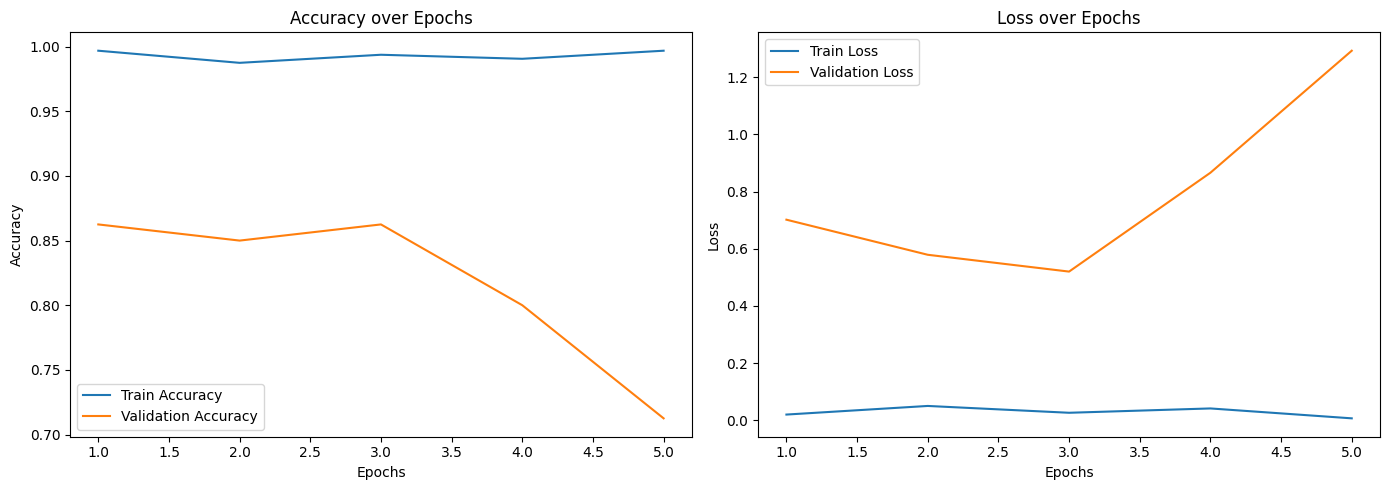

In [5]:
# Préparer les données pour le graphique
metrics = metrics_recorder.get_metrics()

epochs = range(1, len(metrics['train_loss']) + 1)

plt.figure(figsize=(14, 5))

# Graphique pour l'accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Graphique pour la loss
plt.subplot(1, 2, 2)
plt.plot(epochs, metrics['train_loss'], label='Train Loss')
plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Charger le modèle et le tokenizer finetunés
model = BertForSequenceClassification.from_pretrained("./finetuned_BERT")
tokenizer = BertTokenizer.from_pretrained("./finetuned_BERT")

# Fonction pour prédire le sentiment d'un tweet
def predict_sentiment(tweet):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    positive_proba = probabilities[0][1].item()
    return positive_proba

# Liste de tweets à tester
test_tweets = [
    "I can't believe how terrible this service is. Absolutely awful!",
    "Worst experience ever. Totally disappointing and frustrating.",
    "Everything about this product is just so bad. Waste of money.",
    "I'm really not happy with how things turned out. Expected better.",
    "Not impressed with the quality at all. Quite disappointing.",
    "This is not what I ordered. Very misleading.",
    "I was hoping for more, but it's just okay. Not quite what I wanted.",
    "It's alright, but it could be a lot better. Needs improvement.",
    "Service was slow and unresponsive, but the product was decent.",
    "It’s fine, nothing too special but not too bad either.",
    "I had an average experience, nothing to write home about.",
    "It’s okay, does the job but doesn’t exceed expectations.",
    "Pretty good overall, just a few minor issues here and there.",
    "Decent product for the price, happy with the purchase.",
    "Met most of my expectations, would recommend with some reservations.",
    "Really satisfied with this. It’s just what I needed.",
    "Great product, would definitely buy again. Very happy.",
    "Good service and quality, met my expectations well.",
    "Absolutely love this! Exceeded all my expectations.",
    "Best purchase I've made in a while. Highly recommend!",
    "Fantastic experience from start to finish. Couldn't be happier!"
]

# Prédire et afficher le sentiment pour chaque tweet
for tweet in test_tweets:
    prediction = predict_sentiment(tweet)
    sentiment = "Positif" if prediction > 0.5 else "Négatif"
    print(f"Tweet: {tweet}")
    print(f"Score: {prediction:.4f}, Sentiment: {sentiment}")


Tweet: I can't believe how terrible this service is. Absolutely awful!
Score: 0.0301, Sentiment: Négatif
Tweet: Worst experience ever. Totally disappointing and frustrating.
Score: 0.0034, Sentiment: Négatif
Tweet: Everything about this product is just so bad. Waste of money.
Score: 0.0038, Sentiment: Négatif
Tweet: I'm really not happy with how things turned out. Expected better.
Score: 0.0035, Sentiment: Négatif
Tweet: Not impressed with the quality at all. Quite disappointing.
Score: 0.0043, Sentiment: Négatif
Tweet: This is not what I ordered. Very misleading.
Score: 0.0075, Sentiment: Négatif
Tweet: I was hoping for more, but it's just okay. Not quite what I wanted.
Score: 0.0035, Sentiment: Négatif
Tweet: It's alright, but it could be a lot better. Needs improvement.
Score: 0.9637, Sentiment: Positif
Tweet: Service was slow and unresponsive, but the product was decent.
Score: 0.7620, Sentiment: Positif
Tweet: It’s fine, nothing too special but not too bad either.
Score: 0.9938, S